In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow.keras.metrics
import shap
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/data/tracks_with_binary_target.csv')
data.set_index('title', inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [5]:
enc = LabelEncoder()
data['artist'] = enc.fit_transform(data['artist'])

In [6]:
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [7]:
label = 'is_dance_pop'
features = data.columns.drop(label)
X = data[features]
Y = data[label]

<h1>1. Extreme gradient boosting for classification</h1>

In [8]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBClassifier(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='f1', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [9]:
def shap_graphs(model, X):
  expl = shap.Explainer(model, X)
  shap_values = expl(X)
  shap.plots.bar(shap_values)
  shap.plots.beeswarm(shap_values)

In [10]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  return predicted, actual

In [11]:
def draw_roc_curve(Y_test, Y_pred):
  print(f'Roc auc score: {roc_auc_score(Y_test, Y_pred)}')
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='blue')
  x = np.arange(0.0, 1.1, 0.1)
  plt.plot(x, x, color='orange',linestyle='dashed')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.show()

Set the range of parameters for grid search

In [12]:
PARAMS = {
    'max_depth': [2, 3, 5, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250]
}

In [13]:
xgb_params, xgb_score = hyper_parameter_search(X, Y, PARAMS)

Perform hyper parameter search with the above defined parameters using 5-fold cross validation and maximizing f1 score.

In [14]:
print(f'best parameters: {xgb_params}')
print(f'F1 score: {xgb_score}')

best parameters: {'gamma': 0.1, 'learning_rate': 0.003, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250}
F1 score: 0.8216513803873404


In [15]:
xgb_clf = XGBClassifier(
    max_depth = xgb_params['max_depth'],
    min_child_weight = xgb_params['min_child_weight'],
    learning_rate = xgb_params['learning_rate'],
    gamma = xgb_params['gamma'],
    n_estimators = xgb_params['n_estimators']
)

In [16]:
predicted_xgb, actual_xgb = cross_validation_model(X, Y, xgb_clf)

Evaluate model prediction on 5-fold cross validation

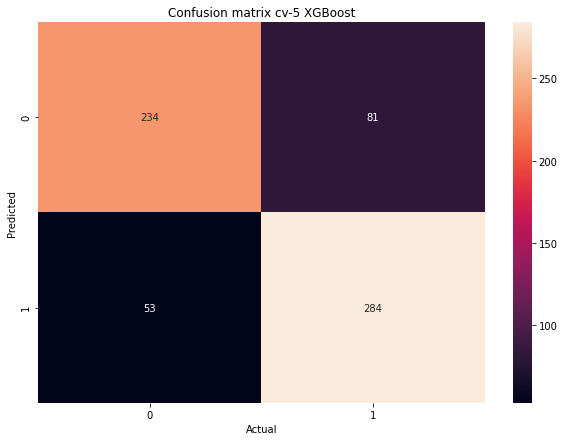

In [17]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_xgb, predicted_xgb), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 XGBoost')
plt.show()

In [18]:
print(classification_report(actual_xgb, predicted_xgb))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       315
           1       0.78      0.84      0.81       337

    accuracy                           0.79       652
   macro avg       0.80      0.79      0.79       652
weighted avg       0.80      0.79      0.79       652



Roc auc score: 0.7927935565917762


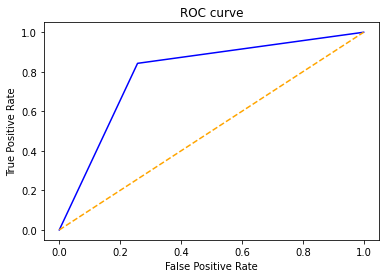

In [19]:
draw_roc_curve(actual_xgb, predicted_xgb)

The xgboost model has promissing scores but they are lower than the random forest results, adaptive boosting and knn.

<h3>Explaining the feature importances of xgboost</h3>

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y,
    test_size=0.2
)

In [21]:
xgb_clf.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.003, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

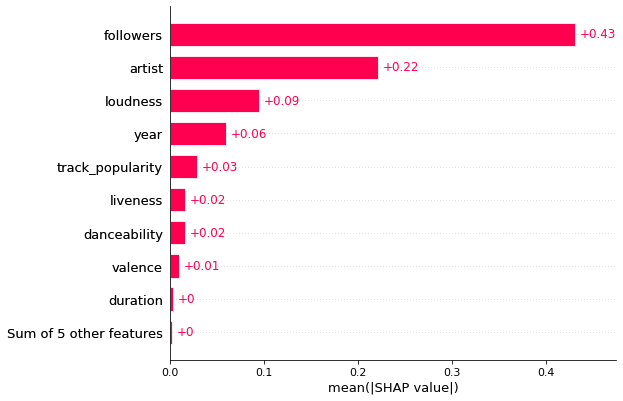

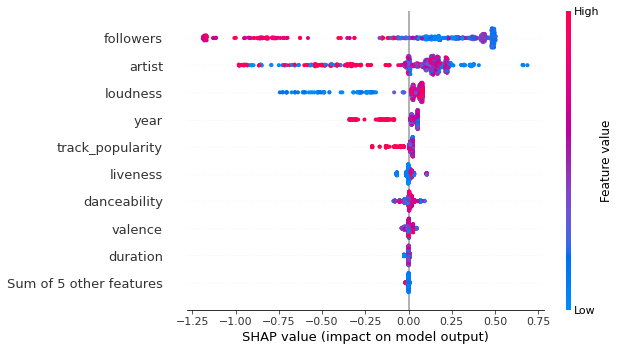

In [22]:
shap_graphs(xgb_clf, X)

The most contributing factor towards target prediction is the attribute followers. As we can see from the shap beeswarm plot, genreally artists wiht mode followers tend to decrease the predictions. In this case this means that for a song to be predicted as dance pop, the value of artist followers would generally be lower with respect to non dance pop songs.
Artist is the next most important attribute. Since the encoding does not have any particular meaning the shap plot is random, but generally one artist make songs from a small number of genres, so this is expected. Next we can see that higer values of danceability dan loudness are associated wiht dance pop songs.

<h1>2. Artificial Neural Network</h1>

In [23]:
def cross_validation_network(X, Y, model, batch=8, ep=100):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train, batch_size=batch, epochs=ep)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  return predicted, actual

I am going to make a neural network with one hidden layer with relu activation function and 32 neurons. The output layer will have 1 neuron and a sigmoid activation since it is a binary classification problem. 

In [27]:
model = Sequential()
model.add(Dense(32, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

I am going to use the Adam optimizer with binary_crossentropy as loss since we are dealing with binary classification. Adam is chosen since it has adaptive learning rates for each parameter. I am going to train the network with 150 epochs and batch size of 8.

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [29]:
pred_ann, actual_ann = cross_validation_network(X, Y, model, 8, 150)

Epoch 1/150
66/66 [==============================] - 0s 2ms/step - loss: 0.8555 - accuracy: 0.4933
Epoch 2/150
66/66 [==============================] - 0s 2ms/step - loss: 0.7263 - accuracy: 0.5432
Epoch 3/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5681
Epoch 4/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6398 - accuracy: 0.6583
Epoch 5/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.6411
Epoch 6/150
66/66 [==============================] - 0s 2ms/step - loss: 0.7348 - accuracy: 0.5931
Epoch 7/150
66/66 [==============================] - 0s 2ms/step - loss: 0.7112 - accuracy: 0.6142
Epoch 8/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6230 - accuracy: 0.6795
Epoch 9/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.6507
Epoch 10/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.6238
Epoch 11/

In [30]:
pred_ann = np.round(pred_ann)

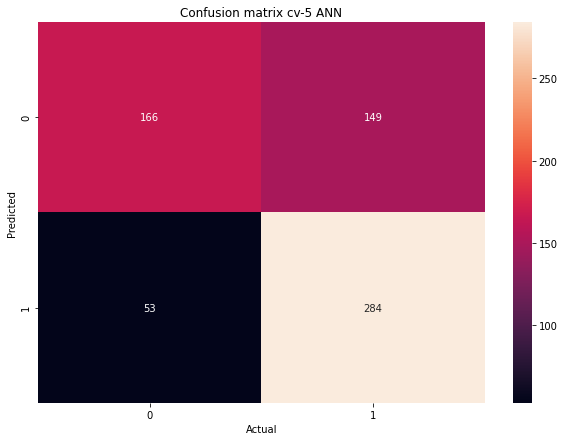

In [31]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_ann, pred_ann), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 ANN')
plt.show()

In [32]:
print(classification_report(actual_ann, pred_ann))

              precision    recall  f1-score   support

           0       0.76      0.53      0.62       315
           1       0.66      0.84      0.74       337

    accuracy                           0.69       652
   macro avg       0.71      0.68      0.68       652
weighted avg       0.71      0.69      0.68       652



Roc auc score: 0.6848570486552683


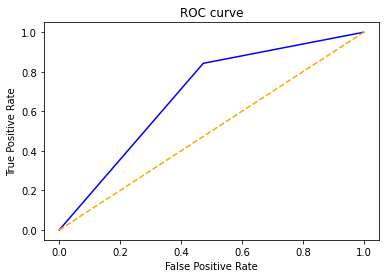

In [33]:
draw_roc_curve(actual_ann, pred_ann)

We can see that this network performs worse than xgboost. This may be due to the fact that the data set is very small and does not contain enough samples for training a neural network.

Let's try the same network but with a sigmoid activation in the hidden layer.

In [34]:
model = Sequential()
model.add(Dense(32, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='sigmoid'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [36]:
pred_ann_sig, actual_ann_sig = cross_validation_network(X, Y, model, 8, 150)

Epoch 1/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5048
Epoch 2/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5029
Epoch 3/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5202
Epoch 4/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4952
Epoch 5/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5182
Epoch 6/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5182
Epoch 7/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5182
Epoch 8/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5182
Epoch 9/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5182
Epoch 10/150
66/66 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.4722
Epoch 11/

In [37]:
pred_ann_sig = np.round(pred_ann_sig)

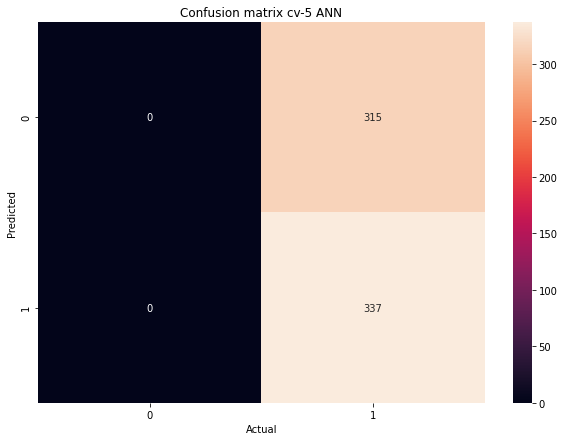

In [38]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(actual_ann_sig, pred_ann_sig), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 ANN')
plt.show()

In [39]:
print(classification_report(actual_ann_sig, pred_ann_sig))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       315
           1       0.52      1.00      0.68       337

    accuracy                           0.52       652
   macro avg       0.26      0.50      0.34       652
weighted avg       0.27      0.52      0.35       652



Roc auc score: 0.5


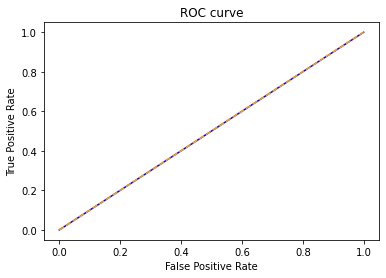

In [40]:
draw_roc_curve(actual_ann_sig, pred_ann_sig)

This network corresponds to random guessing.

<h1>3. Deep neural network</h1>

I am going to try a deep neural network with 6 hidden layers with 64, 32, 16, and 8 neurons and two dropout layers with probability of 0.6. The activation function of the hidden layer is going to be relu and the output layer is going to have one neuron, since it is a binary classification and a sigmoid activation function.

In [41]:
model = Sequential()
model.add(Dense(64, input_dim=len(X.columns), kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(32, kernel_initializer = 'uniform', activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(16, kernel_initializer = 'uniform', activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(8, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

I am going to use the Adam optimizer with binary_crossentropy as loss since we are dealing with binary classification. Adam is chosen since it has adaptive learning rates for each parameter. I am going to train the network with 200 epochs and batch size of 32.

In [42]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 

In [43]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.15)

Epoch 1/200
14/14 [==============================] - 1s 17ms/step - loss: 0.6936 - accuracy: 0.4932 - val_loss: 0.6936 - val_accuracy: 0.4557
Epoch 2/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5181 - val_loss: 0.6942 - val_accuracy: 0.4557
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5385 - val_loss: 0.6948 - val_accuracy: 0.4557
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5294 - val_loss: 0.6957 - val_accuracy: 0.4557
Epoch 5/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5317 - val_loss: 0.6957 - val_accuracy: 0.4557
Epoch 6/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5339 - val_loss: 0.6964 - val_accuracy: 0.4557
Epoch 7/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5339 - val_loss: 0.6975 - val_accuracy: 0.4557
Epoch 8/200


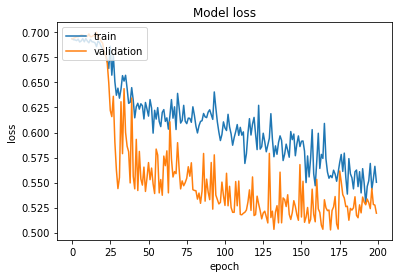

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From the plot above, we can see that the validation error is lower than the training error which is a good sign that the model does not overfit. But the learning is unstable. Maybe more data are needed or more epochs.

In [52]:
pred_dnn, act_dnn = cross_validation_network(X, Y, model, 8, 150)

Epoch 1/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5639 - accuracy: 0.7351
Epoch 2/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5733 - accuracy: 0.7409
Epoch 3/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5764 - accuracy: 0.7198
Epoch 4/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.7274
Epoch 5/150
66/66 [==============================] - 0s 2ms/step - loss: 0.5876 - accuracy: 0.7025
Epoch 6/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5776 - accuracy: 0.7179
Epoch 7/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5868 - accuracy: 0.7179
Epoch 8/150
66/66 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7409
Epoch 9/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5449 - accuracy: 0.7505
Epoch 10/150
66/66 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.6891
Epoch 11/

In [54]:
pred_dnn = np.round(pred_dnn)

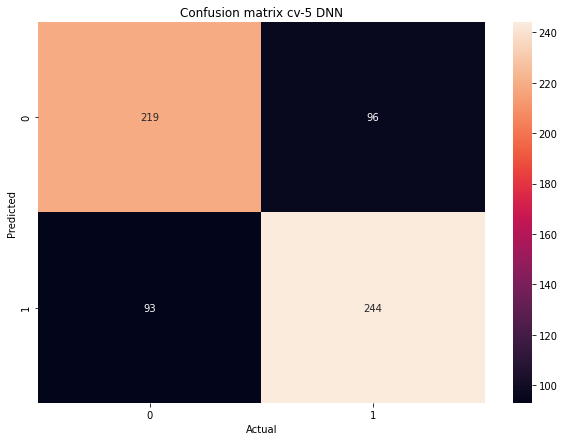

In [56]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(act_dnn, pred_dnn), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix cv-5 DNN')
plt.show()

In [58]:
print(classification_report(act_dnn, pred_dnn))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       315
           1       0.72      0.72      0.72       337

    accuracy                           0.71       652
   macro avg       0.71      0.71      0.71       652
weighted avg       0.71      0.71      0.71       652



Roc auc score: 0.7096368517733503


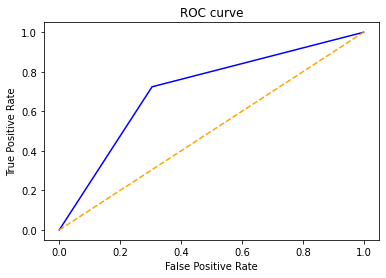

In [59]:
draw_roc_curve(act_dnn, pred_dnn)

The deep neural network has lower performance xgboost but a bit higher than the shallow network. This may be due to the fact that deep networks require a lot of data in order to learn well. In this case the data has fewer than 700 samples which is not suitable.